In [ ]:
##### general libraries import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.metrics import f1_score
import warnings 
warnings.filterwarnings("ignore")

from tqdm import tqdm

import umap

##### scikit learn import
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
import xgboost as xgb
from helper_functions_py import *

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.svm import SVC 

data_version = "20240630"
output_version = "focus_v17_20240703"

# outdir = "/media/hieunguyen/HNSD_mini1/data/outdir"
outdir = "/media/hieunguyen/GSHD_HN01/outdir"
PROJECT = "UMP_Oral_cancer"
code_version = "v17"
path_to_main_input = "/media/hieunguyen/GSHD_HN01/raw_data/UMP_Oral_cancer/input"
path_to_main_output = os.path.join(outdir, PROJECT, output_version)

cluster_score = pd.read_csv("/media/hieunguyen/GSHD_HN01/raw_data/UMP_Oral_cancer/input/240319/cluster_score.csv", sep = ";")
path_to_01_output = os.path.join(path_to_main_output, "01_output", data_version, code_version)
path_to_04_output = os.path.join(path_to_main_output, "04_output", data_version, code_version)
path_to_05_output = os.path.join(path_to_main_output, "05_output", data_version, code_version)
os.system("mkdir -p {}".format(path_to_05_output))

all_cluster_labels = [ 'RNA.consensus.cluster', 
                      'kmean.cluster',
                      'kmean.2clusters.DrNam', 
                      'kmean.3clusters.DrNam', 
                      'merged.cluster12',
                      'merged.cluster13', 
                      'merged.cluster23']
all_cv_scores = dict()
all_best_params = dict()

umapdf = pd.read_csv(os.path.join(path_to_01_output, "umap_RNAseq.csv"), index_col = [0])

featuredf = pd.read_csv(os.path.join(path_to_04_output, "traindf.csv"), index_col = [0]).set_index("SampleID")

featuredf = featuredf.merge(umapdf, right_on = "SampleID", left_on = "SampleID").drop(["V1", "V2"], axis = 1)

all_cluster_labels = ['RNA.consensus.cluster', 'kmean.cluster',
       'kmean.2clusters.DrNam', 'kmean.3clusters.DrNam', 'merged.cluster12',
       'merged.cluster13', 'merged.cluster23']

selected_features = [item for item in featuredf.columns if item not in ["SampleID"] + all_cluster_labels]
selected_cluster_label = 'merged.cluster13'
    
X = featuredf[selected_features].to_numpy()
y = featuredf[selected_cluster_label].to_numpy()
y = [item-1 for item in y] 

all_best_params = dict()
#####----------------------------------------------------------------#####
##### XGBoost model
#####----------------------------------------------------------------#####
model_name = "XGBoost"
param_grid = {    "max_depth": [10, 20, 50, 100], 
                  "n_estimators" : [10, 20, 50, 100],
                  "min_child_weight" : range(1,6,2),  
                  "gamma" : [i/10.0 for i in range(0,5)],
                  "objective": ["binary:logistic"],
                  "tree_method": ["gpu_hist"],
                  "gpu_id": [-1]
             }
                
grid = GridSearchCV(XGBClassifier(), param_grid, refit = True, verbose = True) 
grid.fit(X, y) 
best_params = grid.best_params_
all_best_params[model_name] = best_params

#####----------------------------------------------------------------#####
##### Logistic regression
#####----------------------------------------------------------------#####
model_name = "LR"
param_grid = {
    "random_state" : [411],
    "solver" : ["newton-cg", "lbfgs", "liblinear"],
    "penalty": ["l2"]    
}
grid = GridSearchCV(LogisticRegression(), param_grid, refit = True, verbose = True) 
grid.fit(X, y) 
best_params = grid.best_params_
all_best_params[model_name] = best_params

#####----------------------------------------------------------------#####
##### SVM
#####----------------------------------------------------------------#####
model_name = "SVM"

param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', "linear", "poly", "sigmoid"],
              'probability': [True]} 

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = True) 

grid.fit(X, y) 
best_params = grid.best_params_
all_best_params[model_name] = best_params

#####----------------------------------------------------------------#####
##### FINAL FIT
#####----------------------------------------------------------------#####
n_splits = 10
cv = KFold(n_splits=n_splits)

cv_scores = dict()
models = dict()

clf = GaussianNB()
cv_scores["GaussianNB"] = cross_val_score(clf, X, y, cv = cv)
models["GaussianNB"] = clf.fit(X, y)

clf = MultinomialNB()
cv_scores["MultinomialNB"] = cross_val_score(clf, X, y, cv = cv)
models["MultinomialNB"] = clf.fit(X, y)

clf = GaussianNB()
cv_scores["ComplementNB"] = cross_val_score(clf, X, y, cv = cv)
models["ComplementNB"] = clf.fit(X, y)

# clf = BernoulliNB()
# cv_scores["BernoulliNB"] = cross_val_score(clf, X, y, cv = cv)
# models["BernoulliNB"] = clf.fit(X, y)

clf = XGBClassifier(params = all_best_params["XGBoost"], random_state = 42)
cv_scores["XGBoost"] = cross_val_score(clf, X, y, cv = cv)
models["XGBoost"] = clf.fit(X, y)

clf = SVC(**all_best_params["SVM"])
cv_scores["SVM"] = cross_val_score(clf, X, y, cv = cv)
models["SVM"] = clf.fit(X, y)

clf = LogisticRegression(**all_best_params["LR"])
cv_scores["LR"] = cross_val_score(clf, X, y, cv = cv)
models["LR"] = clf.fit(X, y)

all_cv_scoredf = pd.DataFrame.from_dict(cv_scores, orient="index").T
all_cv_scoredf.to_excel(os.path.join(path_to_05_output, "all_CV_scores_final.xlsx"))


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [2]:
featuredf

,SampleID,Group of Age,Gender,Primary tumor site,Clinical tumor size (cT),Clinical node mestatasis (cN),Clinical distant metastasis (cM),Clinical stage,Pathologic tumor size (pT),Pathologic node mestatasis (pN),...,Worst pattern of invasion (WPOI),Lymphocytic host response (LHR),BrandweinGensler risk level,RNA.consensus.cluster,kmean.cluster,kmean.2clusters.DrNam,kmean.3clusters.DrNam,merged.cluster12,merged.cluster13,merged.cluster23
0,230720_2,2,2,1,3,3,1,4,4,4,...,4,2,2,3,2,2,3,2,1,1
1,230720_3,1,1,1,4,1,1,4,4,1,...,3,1,1,3,1,1,3,2,1,1
2,230720_6,1,1,1,4,3,1,4,4,2,...,3,1,1,2,2,2,2,1,2,1
3,230720_7,2,1,1,3,1,1,3,3,1,...,4,1,2,3,1,1,1,2,1,1
4,230914_9,2,2,1,3,1,1,3,3,2,...,4,2,2,3,1,1,3,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,240202_262,2,2,1,4,2,1,4,3,3,...,2,2,2,3,1,1,3,2,1,1
97,240202_264,2,1,4,4,3,1,4,4,1,...,3,2,2,2,2,2,2,1,2,1
98,240110_265,1,1,1,4,4,1,4,4,1,...,3,2,2,2,2,2,2,1,2,1
99,240202_271,2,1,2,4,4,1,4,4,2,...,3,3,3,3,1,1,3,2,1,1


In [3]:
all_cv_scoredf.mean()

GaussianNB       0.608182
MultinomialNB    0.684545
ComplementNB     0.608182
XGBoost          0.713636
SVM              0.705455
LR               0.695455
dtype: float64

In [4]:
##### save models
os.system("mkdir -p {}".format(os.path.join(path_to_05_output, "models")))
for model_name in models.keys():
    filename = os.path.join(path_to_05_output, "models", '{}.sav'.format(model_name))
    pickle.dump(models[model_name], open(filename, 'wb'))

100%|██████████| 101/101 [00:00<00:00, 263.62it/s]


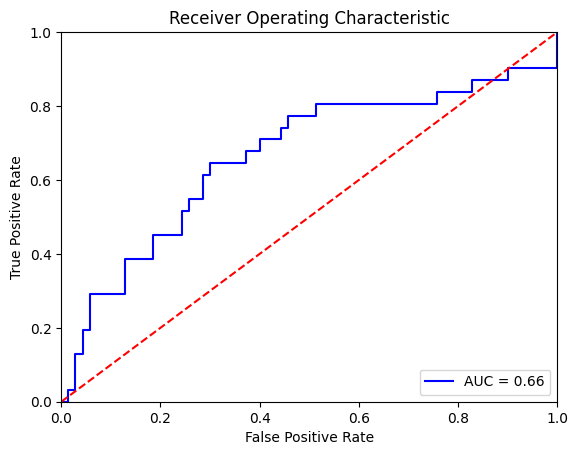

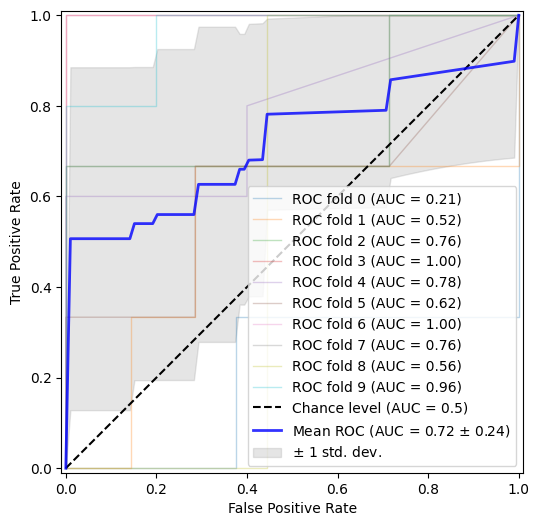

100%|██████████| 101/101 [00:00<00:00, 298.20it/s]


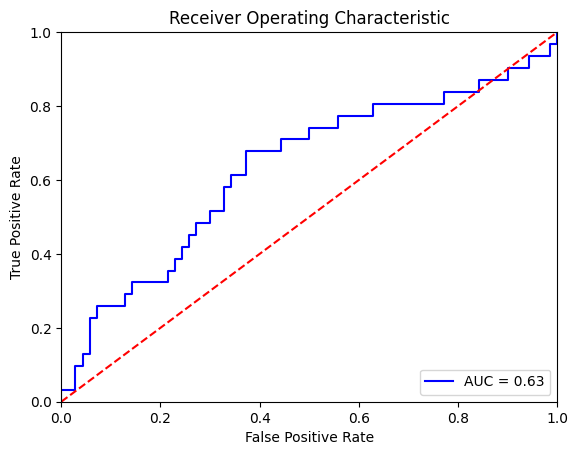

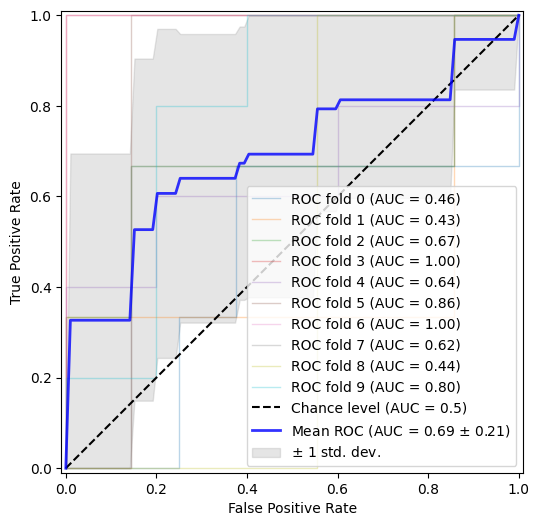

100%|██████████| 101/101 [00:00<00:00, 296.33it/s]


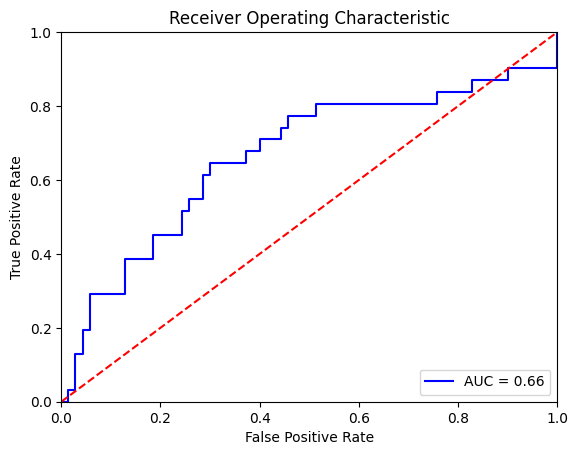

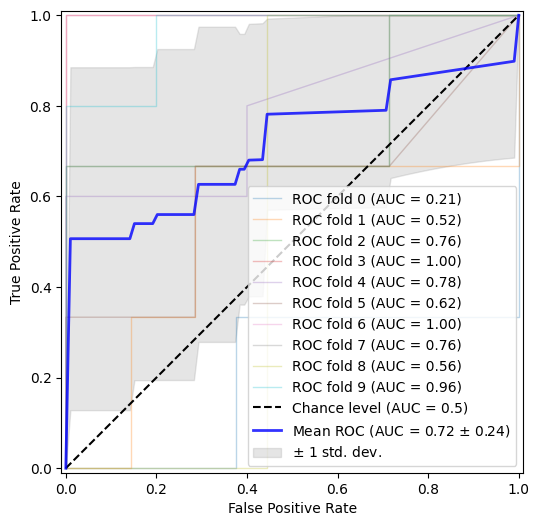

100%|██████████| 101/101 [00:16<00:00,  6.14it/s]


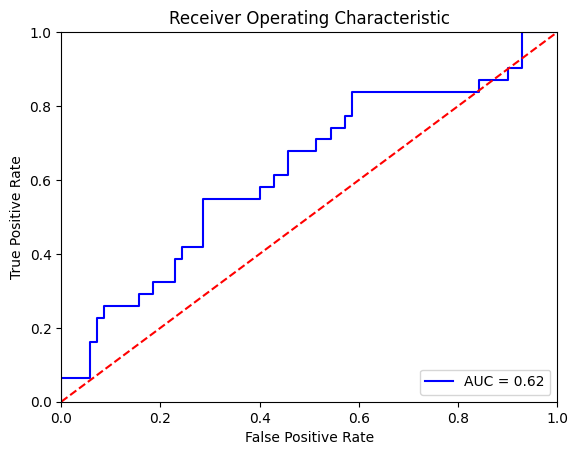

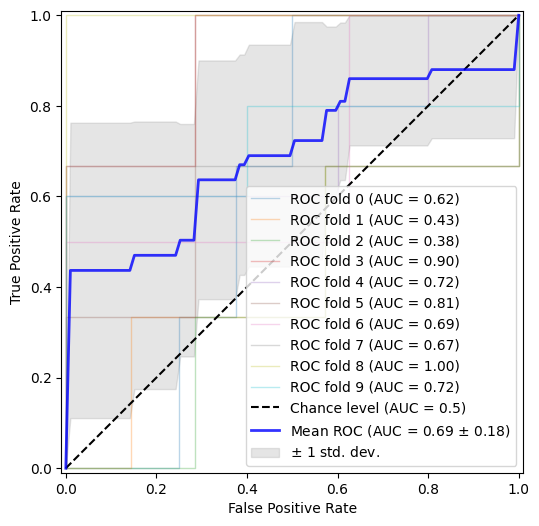

100%|██████████| 101/101 [00:00<00:00, 148.47it/s]


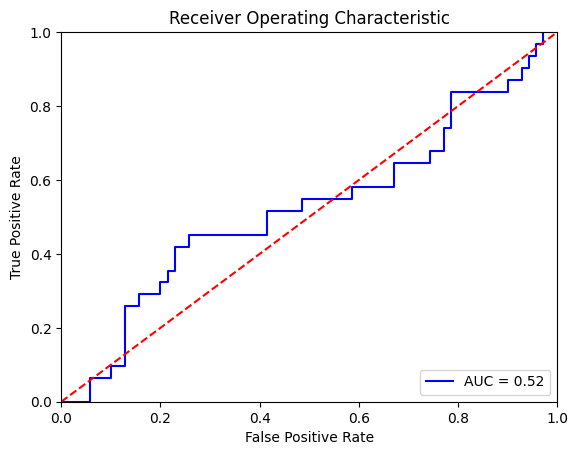

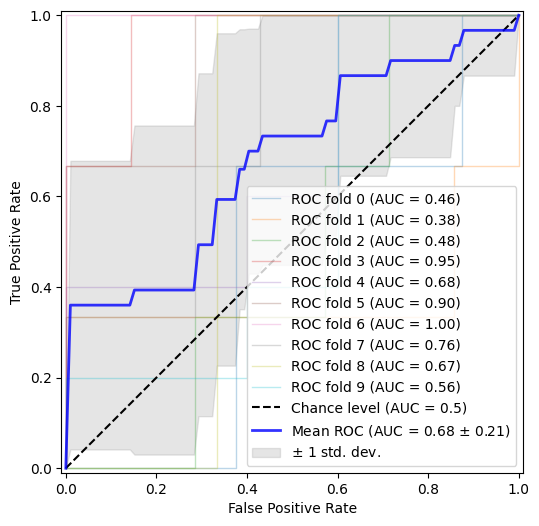

100%|██████████| 101/101 [00:00<00:00, 271.39it/s]


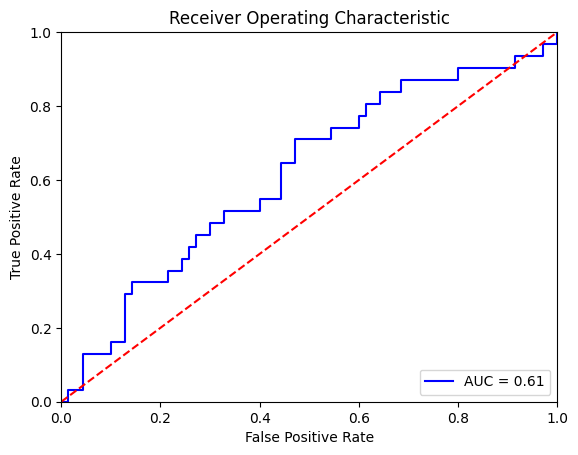

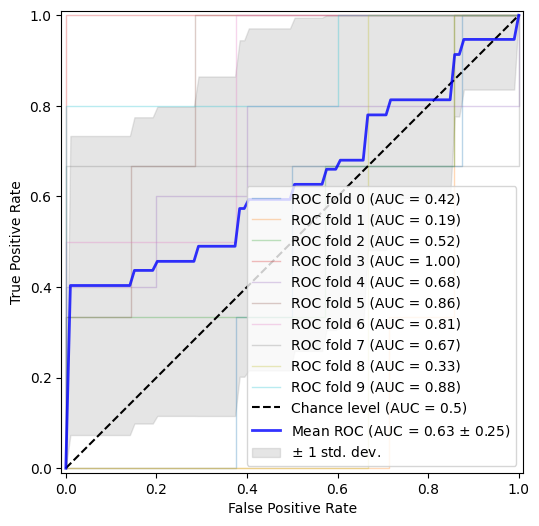

In [5]:
##### TRAIN MODEL WITH KFOLD and LOOCV
loocv_res = dict()
for modelid in models.keys():
    X = featuredf[selected_features].to_numpy()
    y = featuredf[selected_cluster_label].to_numpy()
    y = [item-1 for item in y] 

    preds = []
    true_labels = []
    pred_probas = []
    
    clf = models[modelid]
    for sampleid in tqdm(featuredf.SampleID.unique()):
        Xtrain = featuredf[featuredf["SampleID"] != sampleid][selected_features].to_numpy()
        ytrain = featuredf[featuredf["SampleID"] != sampleid][selected_cluster_label].to_numpy()
        ytrain = [item-1 for item in ytrain] 
        Xtest = featuredf[featuredf["SampleID"] == sampleid][selected_features].to_numpy()
        ytest = featuredf[featuredf["SampleID"] == sampleid][selected_cluster_label].to_numpy()
        ytest = [item-1 for item in ytest] 
        clf.fit(Xtrain, ytrain)
        pred = clf.predict(Xtest)
        preds.append(pred[0])
        true_labels.append(ytest[0])
        pred_probas.append(clf.predict_proba(Xtest)[0])
        
    tmp_resdf = pd.DataFrame(data = featuredf.SampleID.unique(), columns = ["SampleID"])
    tmp_resdf["true_label"] = true_labels
    tmp_resdf["prediction"] = preds
    tmp_resdf[["class_1", "class_2"]] = pred_probas
    loocv_res[modelid] = tmp_resdf
    
    generate_ROC_LOOCV(inputdf = tmp_resdf, 
                       savedir = os.path.join(path_to_05_output, modelid), 
                       figname = "LOOCV_ROC_{}.svg".format(modelid))
    generate_ROC_KFold(clf = clf, 
                       X = X, 
                       y = y, 
                       savedir = os.path.join(path_to_05_output, modelid),
                       figname = "KFOLD_ROC_{}.svg".format(modelid),
                       n_splits = n_splits)

In [6]:
all_cv_scoredf.mean().sort_values()

GaussianNB       0.608182
ComplementNB     0.608182
MultinomialNB    0.684545
LR               0.695455
SVM              0.705455
XGBoost          0.713636
dtype: float64

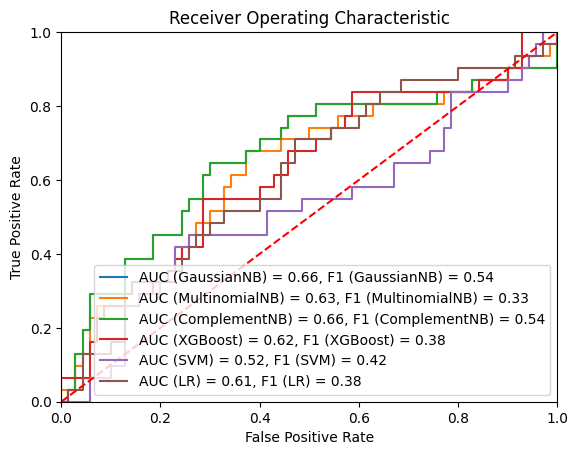

In [24]:
from sklearn.metrics import f1_score
all_f1_scores = dict()
for modelid in loocv_res.keys():
    inputdf = loocv_res[modelid]
    fpr, tpr, threshold = metrics.roc_curve(inputdf["true_label"].to_numpy(), 
                                                inputdf["class_2"].to_numpy())
    all_f1_scores[modelid] = f1_score(inputdf["true_label"].to_numpy(), inputdf["prediction"].to_numpy(), pos_label = 1)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'AUC ({}) = {:.2f}, F1 ({}) = {:.2f}'.format(modelid, roc_auc, modelid, all_f1_scores[modelid]))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic')
figname = "all_LOOCV_ROC_curve"
plt.savefig(os.path.join(path_to_05_output, "{}.svg".format(figname)))
plt.show()


In [8]:
##### prediction on test dataset
testdf = pd.read_csv(os.path.join(path_to_04_output, "testdf.csv"), index_col = [0]).set_index("SampleID")
test_resdf = pd.DataFrame(data = list(testdf.index), columns = ["SampleID"])
for modelid in models.keys():
    clf = models[modelid]
    prediction = clf.predict(testdf.to_numpy())
    tmpdf = pd.DataFrame(data = list(testdf.index), columns = ["SampleID"])
    tmpdf[modelid] = prediction
    test_resdf = test_resdf.merge(tmpdf, right_on = "SampleID", left_on = "SampleID")

test_resdf.to_excel(os.path.join(path_to_05_output, "test_noRNAseq_samples.xlsx"))

,SampleID,GaussianNB,MultinomialNB,ComplementNB,XGBoost,SVM,LR
0,102,1,1,1,0,0,0
1,103,1,0,1,1,1,1
2,104,1,0,1,0,1,1
3,105,1,0,1,0,0,0
4,106,0,0,0,0,0,0
...,...,...,...,...,...,...,...
100,202,0,0,0,0,1,0
101,203,1,0,1,0,0,1
102,204,1,1,1,0,0,0
103,205,0,0,0,0,0,0
